# Battery Temperatures during Supercharging

This notebook calculates the temperature of the battery assuming it dissipates 2% of the total power delivered to it by the supercharger. Heat flows in one-dimension from the battery, flowing across the encapsulation, then flows through an active cooling system kept at ambient temperature.

You can play with the amount of thermal shunting the encapsulation has and see the effect on the peak temperature of the battery. Take note that batteries operate at a narrow temperature range (5 to 45°C). Anything above or below the range could damage the battery.

In [39]:
# import needed modules
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from FastChargingFunctions import PowerProfile, FastChargingBatteryTemperature
import matplotlib.pyplot as plt
from numpy import *
from scipy.integrate import cumtrapz

layout = widgets.Layout(width='auto', height='40px')

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_charging_time(x, y, C):
    index = argwhere(y > C)[0]
    
    m = (x[index]-x[index-1])/(y[index]-y[index-1])
    
    return (m*(C-y[index]) + x[index])[0]


<IPython.core.display.Javascript object>


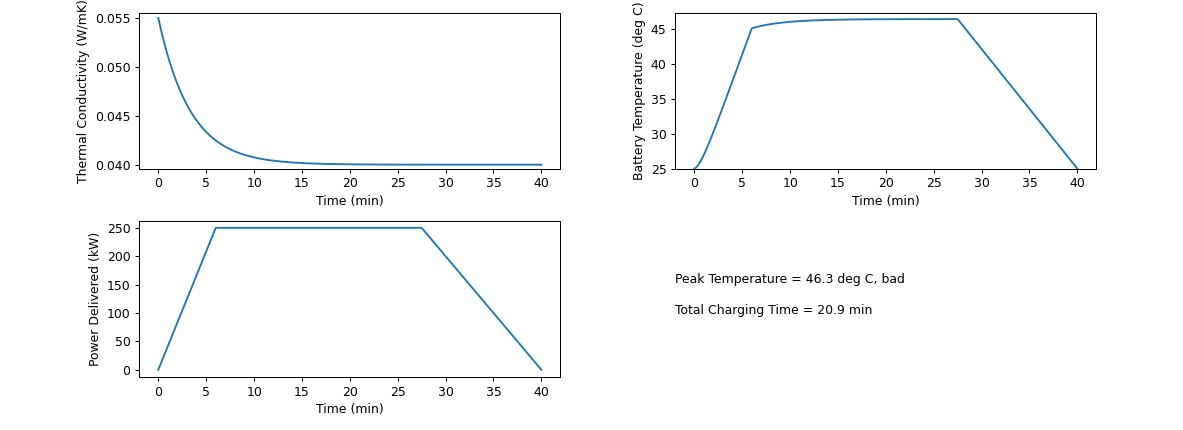

interactive(children=(FloatSlider(value=0.04, description='Transient Thermal Conductivity (W/mK)', layout=Layo…

In [40]:
# create power profile
num_battery_cells = 4410
peak_power = 250e3
heat_dissipation_percentage = 0.01
power_dissipated = peak_power/num_battery_cells * heat_dissipation_percentage
battery_surface_area = 5310e-6 # m^2
vehicle_battery_capacity = 75e3*3600 # watt-second
L = 8e-3

power_ramp_up_time = 6*60 # 6 minutes
charging_time = 40*60

# set up plot
ambient_temp = 25
num_timestamps = 400
VHC = 0.12e6
x = linspace(1e-3, charging_time, num_timestamps)
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Thermal Conductivity (W/mK)")
ttc = 0.08
sstc = 0.03
decay_time = 400
peak_power_duration = 0
yt = sstc + (ttc-sstc)*exp(-5*x/decay_time)
line, = ax.plot(x/60, yt)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Battery Temperature (deg C)")

PP = PowerProfile(power_dissipated/battery_surface_area, power_ramp_up_time, 0*60, charging_time)
Vs = ambient_temp + FastChargingBatteryTemperature(x, yt, L, VHC, PP)
line2, = ax2.plot(x/60, Vs)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_xlabel("Time (min)")
ax3.set_ylabel("Power Delivered (kW)")
true_power_profile = PP(x)*battery_surface_area*num_battery_cells/heat_dissipation_percentage/1000
line3, = ax3.plot(x/60, true_power_profile)

#SOC_over_time = cumtrapz(true_power_profile, x)
#charging_time = get_charging_time(x, SOC_over_time, vehicle_battery_capacity)/60 # to get total minutes
    

ax4 = fig.add_subplot(2, 2, 4)
ax4.axis('off')
t1 = ax4.text(0.0, 0.6, "Peak Temperature = {:.1f} deg C, {}".format(max(Vs), "bad" if max(Vs) >= 45 else "ok"), fontsize=10)
t2 = ax4.text(0.0, 0.4, "")

plt.tight_layout()

def update(ttc=widgets.FloatSlider(value=0.04, min=0, max=0.4, 
                    step=0.001, readout_format='.3f', description="Transient Thermal Conductivity (W/mK)", style= {'description_width': 'initial'}, layout=layout), 
          sstc=widgets.FloatSlider(value=0.04, min=0, max=0.4, 
                    step=0.001, readout_format='.3f', description="Steady State Thermal Conductivity (W/mK)", style= {'description_width': 'initial'}, layout=layout), 
          time_constant=widgets.FloatSlider(value=200, min=0, max=5000, 
                    step=10, readout_format='d', description="Time Constant (s)", style= {'description_width': 'initial'}, layout=layout), 
          peak_power_duration=widgets.FloatSlider(value=0, min=0, max=5000, 
                    step=10, readout_format='d', description="Peak Power Duration (s)", style= {'description_width': 'initial'}, layout=layout), 
           VHC=widgets.FloatSlider(value=0.12, min=0, max=1, 
                    step=0.01, readout_format='.3f', description="VHC (MJ/m3K)", style= {'description_width': 'initial'}, layout=layout)):
    yt = sstc + (ttc-sstc)*exp(-x/time_constant)
    line.set_ydata(yt)
    power_dissipated = peak_power/num_battery_cells * heat_dissipation_percentage
    charging_time = 40*60
    PP = PowerProfile(power_dissipated/battery_surface_area, power_ramp_up_time, peak_power_duration, charging_time)
    Vs = ambient_temp + FastChargingBatteryTemperature(x, yt, L, VHC*1e6, PP)
    line2.set_ydata(Vs)
    ax.set_ylim([0.99*min(ttc, sstc), 1.01*max(ttc, sstc)])
    ax2.set_ylim([ambient_temp, 1.02*max(Vs)])
    power_dissipated = PP(x)
    line3.set_ydata(power_dissipated*num_battery_cells*battery_surface_area/heat_dissipation_percentage/1000)
    
    true_power_profile = power_dissipated*battery_surface_area*num_battery_cells/heat_dissipation_percentage
    
    SOC_over_time = cumtrapz(true_power_profile, x)

    charging_time = get_charging_time(x, SOC_over_time, vehicle_battery_capacity)/60 # to get total minutes
    
    t1.set_text("Peak Temperature = {:.1f} deg C, {}".format(max(Vs), "bad" if max(Vs) >= 45 else "ok"))
    t2.set_text("Total Charging Time = {:.1f} min".format(charging_time))
    fig.canvas.draw()
    

interact(update);    
